
# 📊 Proyecto TelecomX — Predicción de *Churn*

**Objetivo:** predecir qué clientes tienen mayor probabilidad de cancelar el servicio (churn).  

**Pasos:**

1) Cargar dataset y separar datos de entrenamiento y datos de score   
2) EDA visual básica (distribuciones, correlación).  
3) Preprocesamiento
4) Entrenar varios modelos (Regresión Logística, Árbol, Random Forest, KNN).  
5) Comparar métricas (Accuracy, Precision, Recall, F1, AUC) + Matrices de confusión + Curvas ROC.  
6) Elegir el mejor y realizar *scoring* para `df_score`.  
7) Exportar `score_churn.csv` con `Id_cliente`, `prediccion`, `prob_churn`.



In [82]:
# ===============================================================
# 1) Librerías y configuración básica
# ===============================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, accuracy_score, precision_score, recall_score, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

print("✅ Librerías cargadas")

✅ Librerías cargadas


## 2) Cargar dataset

In [83]:
# URL cruda del CSV en GitHub (ajústala si cambias el archivo o su ubicación)
CSV_URL = "https://raw.githubusercontent.com/Alxs68/TelecomX_2_LATAM-ML/main/telecomx_datos_procesados.csv"

# Lee el CSV (asumimos coma como separador y punto como decimal). Cambia si tu archivo usa otras convenciones.
df = pd.read_csv(CSV_URL, sep=",", decimal=".", low_memory=False)
print("Forma del dataset:", df.shape)
display(df.head(3))

# Validación de columnas mínimas
EXPECTED_TARGET = "CHURN_FLAG"
EXPECTED_ID = "ID_CLIENTE"

missing = [c for c in [EXPECTED_TARGET, EXPECTED_ID] if c not in df.columns]
if missing:
    print("\n⚠️ Columnas esperadas faltantes:", missing)
    print("   Por favor, ajusta los nombres abajo si en tu dataset se llaman distinto.")
else:
    print("\n✅ Columnas clave detectadas: CHURN_FLAG e ID_CLIENTE")

Forma del dataset: (7267, 22)


,ID_CLIENTE,CHURN,GENERO,ADULTO_MAYOR,PAREJA,DEPENDIENTES,ANTIGUEDAD_MESES,SERVICIO_TELEFONICO,LINEAS_MULTIPLES,TIPO_INTERNET,SEGURIDAD_EN_LINEA,RESPALDO_EN_LINEA,PROTECCION_DISPOSITIVO,SOPORTE_TECNICO,STREAMING_TV,STREAMING_PELICULAS,TIPO_CONTRATO,FACTURACION_ELECTRONICA,METODO_PAGO,CARGO_MENSUAL,CARGO_TOTAL,CHURN_FLAG
0,0002-ORFBO,No,Mujer,0,Si,Si,9,Si,No,DSL,No,Si,No,Si,Si,No,Un año,Si,Cheque por correo,656,5933.0,0.0
1,0003-MKNFE,No,Hombre,0,No,No,9,Si,Si,DSL,No,No,No,No,No,Si,Mes a mes,No,Cheque por correo,599,5424.0,0.0
2,0004-TLHLJ,Si,Hombre,0,No,No,4,Si,No,Fibra óptica,No,No,Si,No,No,No,Mes a mes,Si,Cheque electrónico,739,28085.0,1.0



✅ Columnas clave detectadas: CHURN_FLAG e ID_CLIENTE


##2.1) Verificación Columnas del DataSet   

In [84]:
print("Columnas del dataset:")
print(df.columns.tolist())

Columnas del dataset:
['ID_CLIENTE', 'CHURN', 'GENERO', 'ADULTO_MAYOR', 'PAREJA', 'DEPENDIENTES', 'ANTIGUEDAD_MESES', 'SERVICIO_TELEFONICO', 'LINEAS_MULTIPLES', 'TIPO_INTERNET', 'SEGURIDAD_EN_LINEA', 'RESPALDO_EN_LINEA', 'PROTECCION_DISPOSITIVO', 'SOPORTE_TECNICO', 'STREAMING_TV', 'STREAMING_PELICULAS', 'TIPO_CONTRATO', 'FACTURACION_ELECTRONICA', 'METODO_PAGO', 'CARGO_MENSUAL', 'CARGO_TOTAL', 'CHURN_FLAG']


## 3) Separación: `df_train` (con churn) y `df_score` (sin churn)

In [85]:

# Separación en entrenamiento (con etiqueta) y scoring (sin etiqueta)
if EXPECTED_TARGET in df.columns:
    df_train = df[df[EXPECTED_TARGET].notnull()].copy()
    df_score = df[df[EXPECTED_TARGET].isnull()].copy()
else:
    raise SystemExit("❌ No se encontró la columna objetivo 'churn'. Renombra tu columna objetivo a 'churn' y vuelve a ejecutar.")

print("Tamaño df_train:", df_train.shape)
print("Tamaño df_score:", df_score.shape)

# Vista rápida de la variable objetivo
print("\nDistribución de churn (df_train):")
display(df_train[EXPECTED_TARGET].value_counts(dropna=False))
print("\nProporción de clases:")
display(df_train[EXPECTED_TARGET].value_counts(normalize=True).rename("proporcion"))


Tamaño df_train: (7043, 22)
Tamaño df_score: (224, 22)

Distribución de churn (df_train):


,count
CHURN_FLAG,
0.0,5174
1.0,1869



Proporción de clases:


,proporcion
CHURN_FLAG,
0.0,0.73463
1.0,0.26537


## 4) EDA visual básica

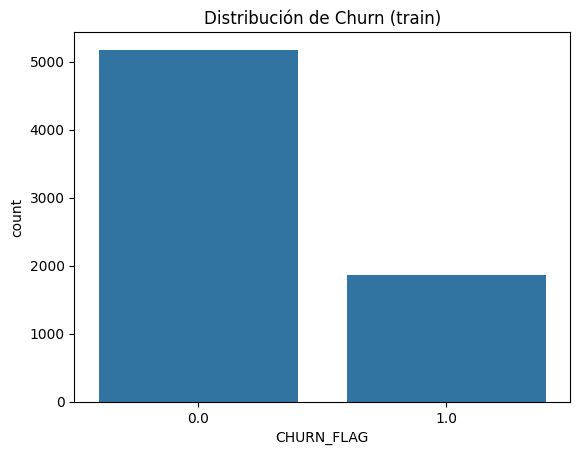

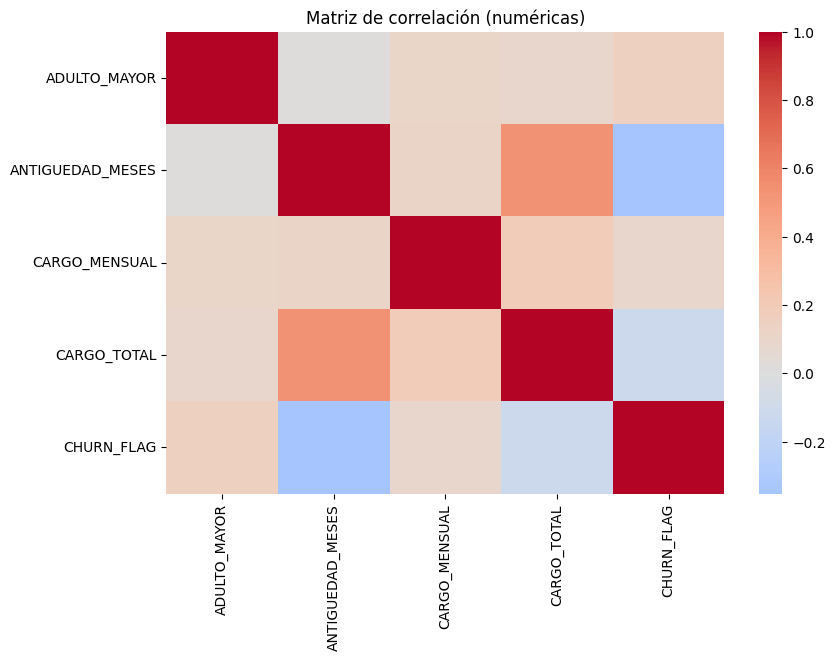

In [86]:

# Conteo de churn
sns.countplot(x=EXPECTED_TARGET, data=df_train)
plt.title("Distribución de Churn (train)")
plt.show()

# Matriz de correlación de numéricas
corr = df_train.corr(numeric_only=True)
plt.figure(figsize=(9,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlación (numéricas)")
plt.show()


## 5) Preparación de datos y `ColumnTransformer`

In [87]:
# Definir X e y (eliminar 'CHURN_FLAG', 'ID_CLIENTE' y 'CHURN' de las predictoras)
X = df_train.drop(columns=[EXPECTED_TARGET] + ([EXPECTED_ID] if EXPECTED_ID in df_train.columns else []) + ['CHURN'], errors="ignore")
y = df_train[EXPECTED_TARGET]

# Detección de tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numéricas:", num_cols[:12], "..." if len(num_cols)>12 else "")
print("Categóricas:", cat_cols[:12], "..." if len(cat_cols)>12 else "")

# Preprocesador: imputa faltantes, escala numéricas y One-Hot en categóricas
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        # Aquí se imputan las columnas numéricas (incluyendo CARGO_TOTAL) con la mediana
        ("num", Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_cols),
        # Aquí se imputan y codifican las categóricas
        ("cat", Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
    ]
)

Numéricas: ['ADULTO_MAYOR', 'ANTIGUEDAD_MESES', 'CARGO_MENSUAL', 'CARGO_TOTAL'] 
Categóricas: ['GENERO', 'PAREJA', 'DEPENDIENTES', 'SERVICIO_TELEFONICO', 'LINEAS_MULTIPLES', 'TIPO_INTERNET', 'SEGURIDAD_EN_LINEA', 'RESPALDO_EN_LINEA', 'PROTECCION_DISPOSITIVO', 'SOPORTE_TECNICO', 'STREAMING_TV', 'STREAMING_PELICULAS'] ...


## 6) División train/test

In [88]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y if y.nunique()<=10 else None
)
print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (4930, 19) X_test: (2113, 19)


## 7) Entrenamiento y evaluación comparativa

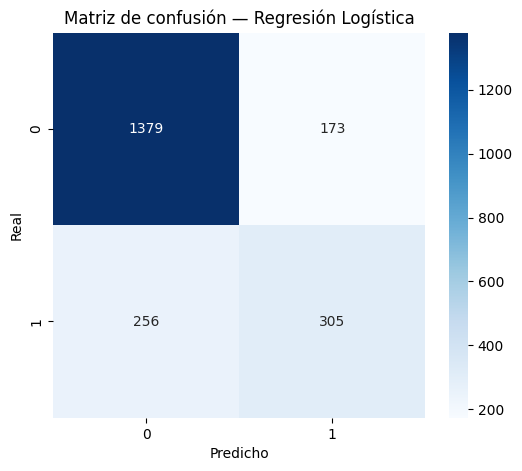

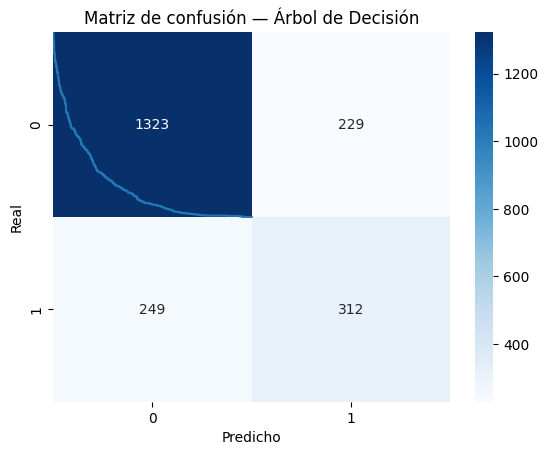

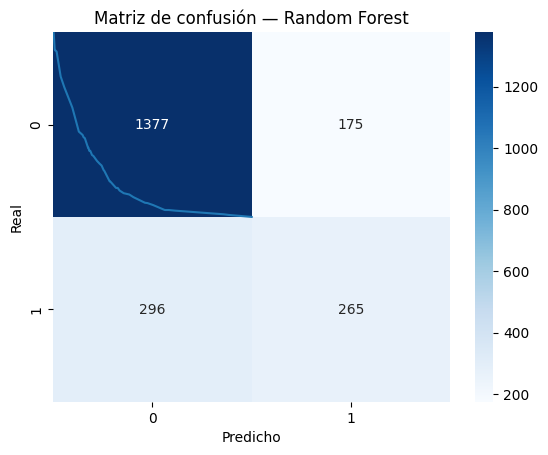

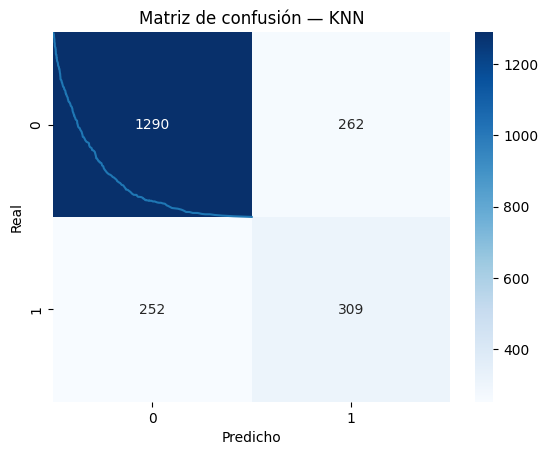

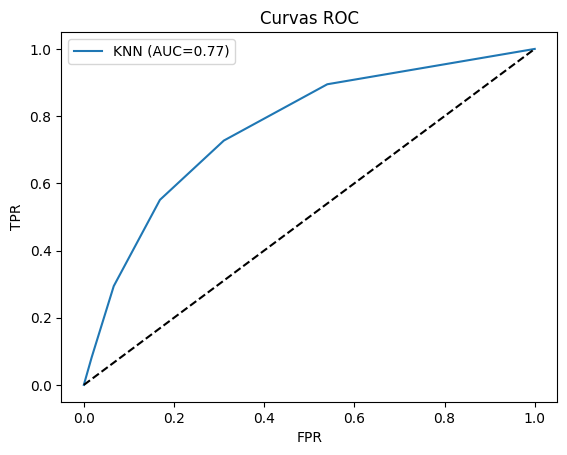


Resumen de métricas:


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Regresión Logística,0.796971,0.638075,0.543672,0.587103,0.838239
1,Árbol de Decisión,0.773781,0.576710,0.556150,0.566243,0.822162
2,Random Forest,0.777094,0.602273,0.472371,0.529471,0.813523
3,KNN,0.756744,0.541156,0.550802,0.545936,0.765688


In [89]:

modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

resultados = []

plt.figure(figsize=(6,5))
for nombre, modelo in modelos.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", modelo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps["clf"], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    resultados.append([nombre, acc, prec, rec, f1, auc])

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión — {nombre}")
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.show()

    # Curva ROC (si hay probabilidades)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.title("Curvas ROC")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend()
plt.show()

res_df = pd.DataFrame(resultados, columns=["Modelo","Accuracy","Precision","Recall","F1","AUC"])
print("\nResumen de métricas:")
display(res_df.sort_values("AUC", ascending=False))


## 8) Selección del mejor modelo y *Scoring* final

In [90]:

# Elegimos el modelo con mayor AUC (si no tiene AUC, priorizamos F1)
mejor_fila = res_df.sort_values(["AUC","F1","Accuracy"], ascending=False).iloc[0]
mejor_nombre = mejor_fila["Modelo"]
print("🏆 Mejor modelo:", mejor_nombre)

# Instanciar el mejor modelo con el mismo preprocesamiento
mejor_map = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Árbol de Decisión": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}
mejor_modelo = Pipeline([("prep", preprocessor), ("clf", mejor_map[mejor_nombre])])
mejor_modelo.fit(X, y)

# Preparar X_score y predecir
if df_score.shape[0] > 0:
    X_score = df_score.drop(columns=[EXPECTED_TARGET] + ([EXPECTED_ID] if EXPECTED_ID in df_score.columns else []), errors="ignore")
    # Probabilidad si el clasificador lo soporta
    if hasattr(mejor_modelo.named_steps["clf"], "predict_proba"):
        df_score["prob_churn"] = mejor_modelo.predict_proba(X_score)[:,1]
    else:
        # Si no hay predict_proba (p.ej., SVM sin probas), aproximamos con 0/1
        df_score["prob_churn"] = mejor_modelo.predict(X_score).astype(float)
    df_score["prediccion"] = (df_score["prob_churn"] >= 0.5).astype(int)

    # Exportar
    cols_out = []
    if EXPECTED_ID in df_score.columns:
        cols_out.append(EXPECTED_ID)
    cols_out += ["prediccion", "prob_churn"]
    df_score[cols_out].to_csv("score_churn.csv", index=False, encoding="utf-8-sig")
    print("✅ Archivo 'score_churn.csv' generado.")
else:
    print("ℹ️ No hay filas en df_score (todas las filas tienen churn). No se genera archivo de scoring.")


🏆 Mejor modelo: Regresión Logística
✅ Archivo 'score_churn.csv' generado.


## 9) Interpretabilidad (importancias / coeficientes)

Top 15 coeficientes por magnitud (Regresión Logística):


,0
ANTIGUEDAD_MESES,-0.884495
TIPO_CONTRATO_Dos años,-0.772497
TIPO_CONTRATO_Mes a mes,0.567700
TIPO_INTERNET_DSL,-0.492074
TIPO_INTERNET_Fibra óptica,0.393978
FACTURACION_ELECTRONICA_No,-0.319636
LINEAS_MULTIPLES_No,-0.283543
SERVICIO_TELEFONICO_Si,-0.275758
DEPENDIENTES_Si,-0.234041
SEGURIDAD_EN_LINEA_Si,-0.233684


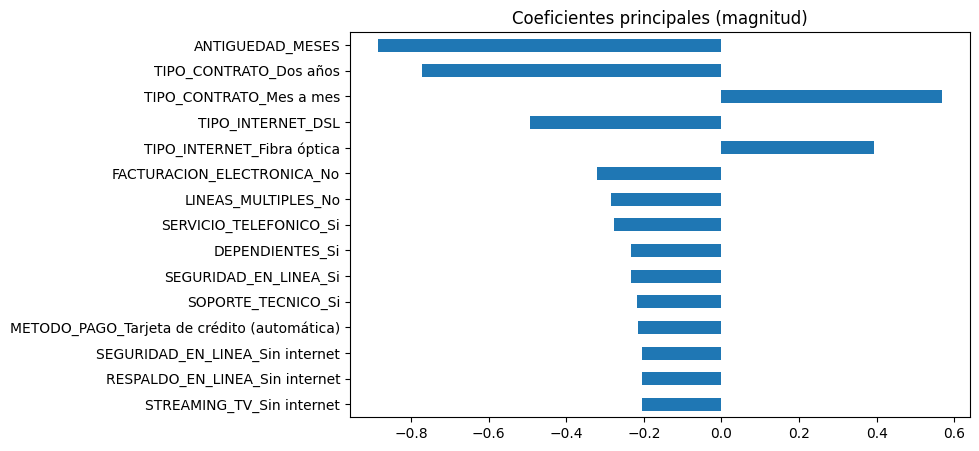

In [91]:

clf = mejor_modelo.named_steps["clf"]

# Importancia de variables (solo si el modelo lo soporta)
if hasattr(clf, "feature_importances_"):
    # Extraer nombres de columnas transformadas
    ohe = mejor_modelo.named_steps["prep"].named_transformers_["cat"]
    num_cols = mejor_modelo.named_steps["prep"].transformers_[0][2]
    cat_cols = mejor_modelo.named_steps["prep"].transformers_[1][2]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if hasattr(ohe, "get_feature_names_out") else []
    feat_names = list(num_cols) + ohe_names

    imps = pd.Series(clf.feature_importances_, index=feat_names).sort_values(ascending=False).head(15)
    print("Top 15 variables (importancia):")
    display(imps)

    plt.figure(figsize=(8,5))
    imps.iloc[::-1].plot(kind="barh")
    plt.title("Importancia de variables (Top 15)")
    plt.show()

elif hasattr(clf, "coef_"):
    # Coeficientes de la Regresión Logística
    ohe = mejor_modelo.named_steps["prep"].named_transformers_["cat"]
    num_cols = mejor_modelo.named_steps["prep"].transformers_[0][2]
    cat_cols = mejor_modelo.named_steps["prep"].transformers_[1][2]
    ohe_names = list(ohe.get_feature_names_out(cat_cols)) if hasattr(ohe, "get_feature_names_out") else []
    feat_names = list(num_cols) + ohe_names

    coefs = pd.Series(clf.coef_[0], index=feat_names).sort_values(key=np.abs, ascending=False).head(15)
    print("Top 15 coeficientes por magnitud (Regresión Logística):")
    display(coefs)

    plt.figure(figsize=(8,5))
    coefs.iloc[::-1].plot(kind="barh")
    plt.title("Coeficientes principales (magnitud)")
    plt.show()
else:
    print("El mejor modelo no expone importancias ni coeficientes para interpretar.")



## 10) Conclusiones rápidas (para completar)

- **Mejor modelo:** completa aquí el modelo ganador y el motivo (ej. mayor AUC con buen Recall).  
- **Variables influyentes:** comenta las más relevantes según importancias/coeficientes.  
- **Recomendaciones de negocio:** define acciones de retención para clientes con alta probabilidad de churn (contacto proactivo, ofertas, mejoras en servicio, etc.).


In [92]:
if 'prediccion' in df_score.columns:
    print("Recuento de predicciones de Churn en df_score:")
    display(df_score['prediccion'].value_counts())
else:
    print("La columna 'prediccion' no se encuentra en df_score. Asegúrate de haber ejecutado la celda de scoring (celda ad43af99).")

Recuento de predicciones de Churn en df_score:


,count
prediccion,
0,169
1,55


In [93]:
print("Distribución de churn (df_train):")
display(df_train[EXPECTED_TARGET].value_counts(dropna=False))
print("\nProporción de clases:")
display(df_train[EXPECTED_TARGET].value_counts(normalize=True).rename("proporcion"))

Distribución de churn (df_train):


,count
CHURN_FLAG,
0.0,5174
1.0,1869



Proporción de clases:


,proporcion
CHURN_FLAG,
0.0,0.73463
1.0,0.26537


In [94]:
if 'prob_churn' in df_score.columns and EXPECTED_ID in df_score.columns:
    print("Clientes con escala de colores por probabilidad de Churn (Scoring), ordenados por probabilidad:")
    # Ordenar por 'prob_churn' de mayor a menor
    df_score_sorted = df_score.sort_values(by='prob_churn', ascending=False).copy()
    # Aplicar escala de colores a las columnas 'prob_churn' y 'ID_CLIENTE' (Rojo más intenso para alta prob)
    # Usamos gmap para basar el color en 'prob_churn' para ambas columnas
    styled_df = df_score_sorted.style.background_gradient(subset=[EXPECTED_ID, 'prob_churn'],
                                                         cmap='Reds',
                                                         gmap=df_score_sorted['prob_churn'])
    display(styled_df)
elif 'prob_churn' in df_score.columns:
     print("Clientes con escala de colores por probabilidad de Churn (Scoring), ordenados por probabilidad:")
    # Ordenar por 'prob_churn' de mayor a menor
     df_score_sorted = df_score.sort_values(by='prob_churn', ascending=False).copy()
    # Aplicar escala de colores a la columna 'prob_churn' (Verde oscuro para alta prob)
     styled_df = df_score_sorted.style.background_gradient(subset=['prob_churn'], cmap='Greens')
     display(styled_df)
elif EXPECTED_ID not in df_score.columns:
    print(f"⚠️ La columna '{EXPECTED_ID}' no se encuentra en df_score.")
else:
    print("⚠️ La columna 'prob_churn' no se encuentra en df_score. Asegúrate de haber ejecutado la celda de scoring (celda ad43af99).")

Clientes con escala de colores por probabilidad de Churn (Scoring), ordenados por probabilidad:


,ID_CLIENTE,CHURN,GENERO,ADULTO_MAYOR,PAREJA,DEPENDIENTES,ANTIGUEDAD_MESES,SERVICIO_TELEFONICO,LINEAS_MULTIPLES,TIPO_INTERNET,SEGURIDAD_EN_LINEA,RESPALDO_EN_LINEA,PROTECCION_DISPOSITIVO,SOPORTE_TECNICO,STREAMING_TV,STREAMING_PELICULAS,TIPO_CONTRATO,FACTURACION_ELECTRONICA,METODO_PAGO,CARGO_MENSUAL,CARGO_TOTAL,CHURN_FLAG,prob_churn,prediccion
4579,6272-HWGNQ,nan,Mujer,0,No,No,1,Si,Si,Fibra óptica,No,No,No,No,No,Si,Mes a mes,Si,Cheque electrónico,850,85.000000,nan,0.800085,1
4976,6807-HWZBE,nan,Hombre,0,Si,No,2,Si,Si,Fibra óptica,No,No,Si,No,Si,No,Mes a mes,Si,Cheque electrónico,9145,17145.000000,nan,0.791110,1
4396,6022-MXOMF,nan,Mujer,1,No,No,1,Si,Si,Fibra óptica,No,No,No,No,No,No,Mes a mes,Si,Cheque electrónico,742,742.000000,nan,0.790135,1
1657,2353-VPYNS,nan,Hombre,1,No,No,1,Si,Si,Fibra óptica,No,No,No,No,No,No,Mes a mes,Si,Cheque electrónico,7365,7365.000000,nan,0.789749,1
3202,4471-OIIDG,nan,Mujer,0,No,No,10,Si,Si,Fibra óptica,No,No,Si,No,Si,Si,Mes a mes,Si,Cheque electrónico,1006,10602.000000,nan,0.789198,1
5714,7808-NBWYW,nan,Mujer,1,Si,No,3,Si,No,Fibra óptica,No,No,No,No,Si,No,Mes a mes,Si,Cheque electrónico,804,22405.000000,nan,0.772946,1
4860,6648-RXFRG,nan,Hombre,0,No,No,7,Si,Si,Fibra óptica,No,No,No,No,No,Si,Mes a mes,Si,Cheque electrónico,868,62035.000000,nan,0.764095,1
374,0534-JRNIG,nan,Mujer,0,No,No,6,Si,Si,Fibra óptica,No,No,No,No,Si,Si,Mes a mes,Si,Transferencia bancaria (automática),9355,5364.000000,nan,0.763587,1
3619,4988-RZJHG,nan,Mujer,0,Si,No,8,Si,Si,Fibra óptica,No,No,No,No,No,Si,Mes a mes,Si,Cheque electrónico,849,76495.000000,nan,0.762017,1
2733,3781-LIPVO,nan,Mujer,0,Si,No,7,Si,Si,Fibra óptica,No,No,No,No,Si,No,Mes a mes,Si,Cheque electrónico,865,5825.000000,nan,0.759907,1


## 10) Conclusiones rápidas

Como asesor de análisis de datos, les presento las conclusiones clave de nuestro proyecto para predecir qué clientes podrían dejarnos (churn):

-   **Sobre nuestro modelo:** Armamos un modelo que nos ayuda a identificar a los clientes con alta probabilidad de irse. De los que probamos, el que mejor funcionó fue uno llamado **Regresión Logística**. Piensen en él como la herramienta que mejor nos ayuda a "adivinar" quién está en riesgo de irse.

-   **¿Qué hace que un cliente se vaya?** Analizamos qué características de los clientes influyen más en su decisión de quedarse o irse. Lo más importante que encontramos es:
    *   **Antigüedad:** Los clientes que llevan más tiempo con nosotros son más fieles. Los nuevos se van más fácilmente.
    *   **Tipo de Contrato:** ¡Este es clave! Los que tienen contratos a **dos años** casi nunca se van. La mayoría de los que se van tienen contratos **mes a mes**.
    *   **Tipo de Internet:** Vimos que los clientes con **Fibra óptica** tienden a irse más que los que tienen otro tipo de internet como DSL. Esto es algo que deberíamos investigar más a fondo.
    *   Otros factores como si usan **facturación electrónica** o tienen **servicios adicionales** también influyen, pero menos que los anteriores.

-   **¿Qué hacemos ahora? ¡Plan de acción!** Con esta información, tenemos una lista (el "scoring") de clientes que nuestro modelo predice que se irán. Aquí algunas ideas para el negocio:
    *   **Prioricemos a los clientes en riesgo:** Identifiquemos a los clientes con alta probabilidad de *churn* en la lista que generamos (los que salieron con colores más oscuros o probabilidades altas) y contactémoslos proactivamente. Podríamos ofrecerles algo especial para que se queden o escuchar sus problemas.
    *   **Miremos de cerca la Fibra óptica:** Investiguemos por qué los clientes de Fibra óptica se van más. ¿Es la calidad? ¿El precio?
    *   **Promovamos los contratos largos:** Incentivemos a los clientes a pasarse a contratos de dos años, explicando los beneficios. Esto parece una buena estrategia para retenerlos.
    *   **Revisemos las políticas de facturación y servicios:** Analicemos si hay algo en estos puntos que esté molestando a los clientes.

En resumen, este análisis nos da una señal de alerta temprana y nos dice en qué características de los clientes debemos enfocarnos para evitar que se vayan. Estamos listos para usar esta lista de clientes en riesgo para lanzar campañas de retención dirigidas.